# Helpers

In [1]:
import numpy as np 
import scipy.sparse as sps
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import scipy 
import os
import datetime
import argparse
from IPython.display import clear_output

In [2]:
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.nn import functional as F
import copy
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 100 # default is 75
plt.style.use('default')
from tqdm import tqdm

In [3]:
from diff_map_code import *

# Data

In [4]:
fname = "ground_data/butane_metad_nonaligned.npz" #butane_metad.npz DNMTBut.npz butane_hightemp.npz
inData = np.load(fname)
print("Keys in data:")
print(list(inData.keys()))

data_meta = inData["data"]
dataMetaD = data_meta
print("Data shape from trajectory:")
print(dataMetaD.shape)
dihedralsMetaD = inData["dihedrals"] # the one dim dihedral angles
potentialMetaD = inData["potential"] # potential related to the particular data point
print(potentialMetaD.shape)
print(dihedralsMetaD.shape)
kbT_roomtemp = inData["kbT_roomtemp"]

Keys in data:
['data', 'data_all_atom', 'dihedrals', 'potential', 'kbT', 'kbT_roomtemp', 'free_energy', 'biasFactor', 'biasWidth', 'height', 'frequency']
Data shape from trajectory:
(100000, 12)
(100000,)
(100000,)


## Visualize Dihedrals

In [5]:
data = dataMetaD[::10, :]
dihedrals = dihedralsMetaD[::10]
potentials = potentialMetaD[::10]
target_measure = np.exp(-potentials/(kbT_roomtemp))

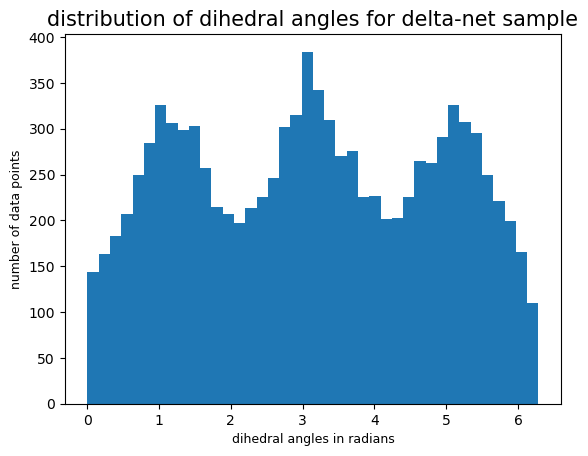

In [6]:
plt.hist(dihedrals, 40) 
plt.title("distribution of dihedral angles for delta-net sample", fontsize = 15)
plt.xlabel("dihedral angles in radians", fontsize = 9)
plt.ylabel("number of data points", fontsize = 9)
plt.savefig("dihedral_dist_metad.pdf")

# Apply translation and rotation invariant embedding

In [12]:
from feature_maps import recenter_bond_torch

In [13]:
data = np.apply_along_axis(recenter_bond_torch, 1, data)

## Compute TMD map

In [17]:
data.shape

(10000, 12)

In [18]:
target_measure_manifold = np.ones(data.shape[0])

In [19]:
n_neighbors = 8192
# use epsilon = 100.0 for all atom
# use epsilon = 50.0 for carbons only
print("sparse dmaps!")
[stationary, K, L] = create_laplacian_sparse(data, \
                                             target_measure_manifold, \
                                             epsilon=50.0,\
                                             n_neighbors=n_neighbors)

sparse dmaps!
Data type of squared distance matrix: <class 'scipy.sparse._csr.csr_matrix'>
Ratio of nonzeros to zeros in kernel matrix: 0.83126342


In [20]:
diffcoords, eigvecs, eigvals = compute_spectrum_sparse(L, stationary, num_eigvecs=10)

Text(0.5, 1.0, 'Decay of eigenvalues of transition matrix $P = (I + \\epsilon L)$')

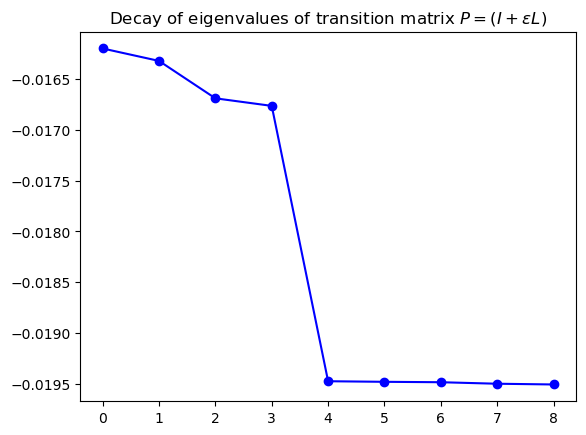

In [21]:
plt.plot(eigvals, 'bo-')
plt.title(f"Decay of eigenvalues of transition matrix $P = (I + \epsilon L)$")

## Load tmdmap

In [22]:
size_vec = np.pi - np.abs(dihedrals - np.pi)
dihedrals_vec = np.abs(dihedrals - np.pi)

In [23]:
dihedrals_vec.shape

(10000,)

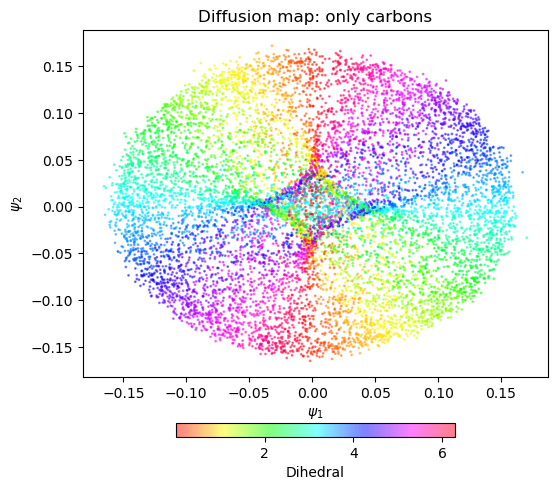

In [30]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
p = ax.scatter(diffcoords[:, 1], diffcoords[:, 2], \
               c=dihedrals, cmap='hsv', s=1.0, alpha=0.5)
ax.set_xlabel(f"$\psi_1$")
ax.set_ylabel(f"$\psi_2$")
# ax.set_zlabel(f"$\psi_3$")
fig.colorbar(p,location='bottom', shrink=0.6, pad=0.1, label='Dihedral')
# ax.view_init(elev=30, azim=-150)
ax.set_title("Diffusion map: only carbons")
plt.show()

(array([ 12.,  66., 114., 139., 121., 155., 176., 185., 164., 192., 178.,
        202., 193., 188., 160., 202., 225., 246., 239., 257., 259., 295.,
        352., 442., 487., 445., 379., 333., 228., 278., 221., 233., 220.,
        200., 196., 168., 189., 197., 157., 171., 164., 153., 157., 132.,
        149., 129., 130.,  83.,  33.,   6.]),
 array([-0.16459081, -0.15786633, -0.15114185, -0.14441737, -0.13769288,
        -0.1309684 , -0.12424392, -0.11751944, -0.11079495, -0.10407047,
        -0.09734599, -0.09062151, -0.08389702, -0.07717254, -0.07044806,
        -0.06372358, -0.0569991 , -0.05027461, -0.04355013, -0.03682565,
        -0.03010117, -0.02337668, -0.0166522 , -0.00992772, -0.00320324,
         0.00352125,  0.01024573,  0.01697021,  0.02369469,  0.03041917,
         0.03714366,  0.04386814,  0.05059262,  0.0573171 ,  0.06404159,
         0.07076607,  0.07749055,  0.08421503,  0.09093952,  0.097664  ,
         0.10438848,  0.11111296,  0.11783744,  0.12456193,  0.13128641,
 

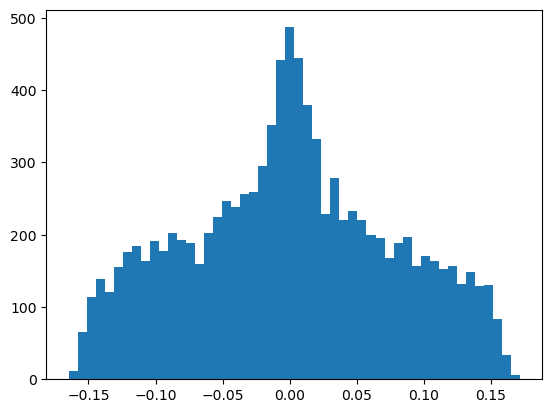

In [33]:
plt.hist(diffcoords[:,2], bins=50)

In [101]:
azim = ax.azim
roll = ax.roll
elev = ax.elev

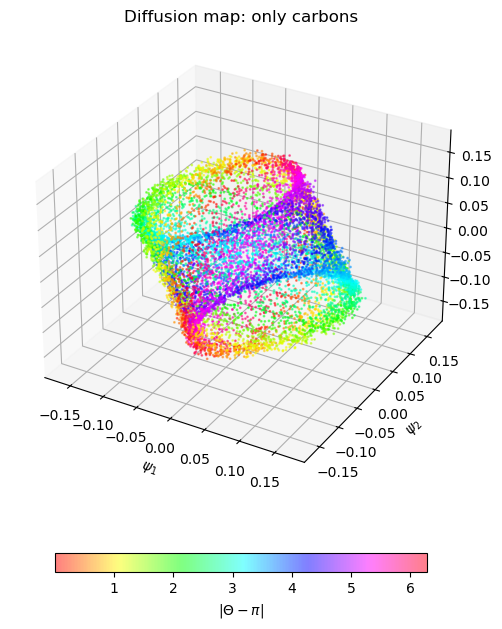

In [35]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
p = ax.scatter(diffcoords[:,0], diffcoords[:, 2], diffcoords[:,3], \
               c=dihedrals, cmap='hsv', s=1.0, alpha=0.5)
ax.set_xlabel(f"$\psi_1$")
ax.set_ylabel(f"$\psi_2$")
# ax.set_zlabel(f"$\psi_3$")
fig.colorbar(p,location='bottom', shrink=0.6, pad=0.1, label=f'$|\Theta - \pi|$')
# ax.view_init(elev=30, azim=-150)
ax.set_title("Diffusion map: only carbons")
# ax.view_init(azim=azim-160, elev=elev, roll=roll)
plt.show()